In [1]:
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

from config import *

In [2]:
PLOT_EXPORT = False
PATH_PLOT_EXPORT = 'data_psd_comparison_subfigs.eps'

In [3]:
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 14}

mpl.rc('font', **font)


scalingConst = PSD_SCALING_CONST

BASE_DIR = 'comparison_results/2025_05_08/'


data_order = ['R', 'H', 'W']
model_order = ['FFNN', 'H', 'W', 'WH']


In [4]:
def load_results(filename):
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)

    y_test = b['y_test']
    y_test_lin = b['y_test_lin']
    y_test_nl = b['y_test_nl']
    y_test_lin = b['y_test_lin']
    noise = b['noise']
    yVar = b['yVar']
    chanLen = b['chanLen'] if 'chanLen' in b else b['CHANNEL_LEN']

    return y_test, y_test_lin, y_test_nl, noise, yVar, chanLen


def getPlotPSD(y_test, noise, params, yVar=1):
	# Computes smoothed FFT according to Balatsoukas' "plotPSD". Used to indidivually plot spectra of SI signal and noise
    # Calculate spectra
    samplingFreqMHz = params['samplingFreqMHz']
    fftpoints = 4096
    scalingConst = samplingFreqMHz*1e6
    freqAxis = np.linspace(-samplingFreqMHz/2,samplingFreqMHz/2,fftpoints)
    savgolWindow = 45
    savgolDegree = 1

    noisefft = np.fft.fftshift(np.fft.fft(noise/np.sqrt(scalingConst), fftpoints, axis=0, norm="ortho"))
    yTestFFT = np.fft.fftshift(np.fft.fft(y_test/np.sqrt(scalingConst), fftpoints, axis=0, norm="ortho"))

    # Plot spectra
    toPlotyTestFFT = 10*np.log10(savgol_filter(np.power(np.abs(yTestFFT),2),savgolWindow,savgolDegree))
    toPlotnoisefft = 10*np.log10(savgol_filter(np.power(np.abs(noisefft),2),savgolWindow,savgolDegree))

    return freqAxis, toPlotyTestFFT, toPlotnoisefft

def get_SIC_attenuation(y_test, y_test_lin, y_test_nl, noise, yVar):

    yTestPower = 10*np.log10(np.mean(np.abs(y_test)**2))
    yTestLinCancPower = 10*np.log10(np.mean(np.abs(y_test-y_test_lin)**2))
    yTestNonLinCancPower = 10*np.log10(np.mean(np.abs(((y_test-y_test_lin)/np.sqrt(yVar)-y_test_nl)*np.sqrt(yVar))**2))


    att_lin = yTestPower-yTestLinCancPower
    att_nl = yTestLinCancPower-yTestNonLinCancPower

    return att_lin, att_nl

### Plot: Compare Spectra

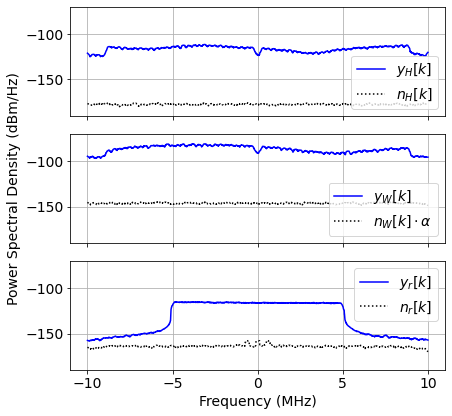

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(6.5, 6))

#iterate exemplary result files to get different data
for idx, rf in enumerate([BASE_DIR+'data_H_model_FFNN_linSIC_no.pkl', BASE_DIR+'data_W_model_FFNN_linSIC_no.pkl', BASE_DIR+'data_R_model_FFNN_linSIC_no.pkl']):

    y_test, y_test_lin, y_test_nl, noise, yVar, chanLen = load_results(rf)

    freqAxis, yTestPSD, noisePSD = getPlotPSD(y_test/np.sqrt(scalingConst), noise/np.sqrt(scalingConst), {'hSILen': chanLen, 'samplingFreqMHz': 20}, yVar)
    if idx == 0:
        ax[0].plot(freqAxis, yTestPSD, 'b-', label='$y_H[k]$')
        ax[0].plot(freqAxis, noisePSD, 'k:', label='$n_H[k]$')
        ax[0].grid()
        ax[0].legend(loc='lower right')
        ax[0].set_xticklabels({})
    elif idx == 1:
        ax[1].plot(freqAxis, yTestPSD, 'b-', label='$y_W[k]$')
        ax[1].plot(freqAxis, noisePSD+50, 'k:', label='$n_W[k] \cdot \\alpha$') # +LNA gain 50dB
        ax[1].grid()
        ax[1].legend(loc='lower right')
        ax[1].set_ylim((-210, -70))
        ax[1].set_ylabel('Power Spectral Density (dBm/Hz)')
        ax[1].set_xticklabels({})
    elif idx == 2:
        ax[2].plot(freqAxis, yTestPSD, 'b-', label='$y_r[k]$')
        ax[2].plot(freqAxis, noisePSD, 'k:', label='$n_r[k]$')
        ax[2].grid()
        ax[2].legend(loc='upper right')

plt.xlabel('Frequency (MHz)')
#plt.legend(['Real, SI-Signal', 'Real, Noise', 'Synth. Hammerstein, SI-Signal', 'Synth. Hammerstein, Noise', 'Synth. Wiener, SI-Signal', 'Synth. Wiener, Noise'])

plt.tight_layout()
plt.setp(ax, ylim=(-190, -70))



if PLOT_EXPORT:
    fig.savefig(PATH_PLOT_EXPORT,format='eps', bbox_inches='tight')

### Compare SIC Performance

In [18]:
# Print lin. SIC only using exemplary results file for each dataset
print('Data \t lin. SIC [dB]')
print('------------------------------------------')
for ii in range(len(data_order)):
    rf = BASE_DIR+'data_'+data_order[ii]+'_model_'+model_order[0]+'_linSIC_yes.pkl' #result_files[ii][jj]
    y_test, y_test_lin, y_test_nl, noise, yVar, chanLen = load_results(rf)
    att_lin, _ = get_SIC_attenuation(y_test, y_test_lin, y_test_nl, noise, yVar)
    print(data_order[ii], '\t', f'{att_lin:.1f}')
print('\n')

# Print SIC results
print('Data \t Model \t SIC [dB] \t SIC with lin. SIC [dB]')
for ii in range(len(data_order)):
    print('------------------------------------------')
    for jj in range(len(model_order)):

        rf = BASE_DIR+'data_'+data_order[ii]+'_model_'+model_order[jj]+'_linSIC_no.pkl' #result_files[ii][jj]
        y_test, y_test_lin, y_test_nl, noise, yVar, chanLen = load_results(rf)
        att_lin, att_nl = get_SIC_attenuation(y_test, y_test_lin, y_test_nl, noise, yVar)
        att_total = att_lin + att_nl

        rf = BASE_DIR+'data_'+data_order[ii]+'_model_'+model_order[jj]+'_linSIC_yes.pkl' #result_files[ii][jj]
        y_test, y_test_lin, y_test_nl, noise, yVar, chanLen = load_results(rf)
        att_lin, att_nl = get_SIC_attenuation(y_test, y_test_lin, y_test_nl, noise, yVar)
        att_total_with_lin_SIC = att_lin + att_nl

        print(data_order[ii], '\t', model_order[jj], '\t', f'{att_total:.1f}', '\t\t', f'{att_total_with_lin_SIC:.1f}')


Data 	 lin. SIC [dB]
------------------------------------------
R 	 37.9
H 	 10.2
W 	 10.4


Data 	 Model 	 SIC [dB] 	 SIC with lin. SIC [dB]
------------------------------------------
R 	 FFNN 	 39.8 		 44.6
R 	 H 	 38.1 		 42.9
R 	 W 	 39.0 		 42.4
R 	 WH 	 39.1 		 42.9
------------------------------------------
H 	 FFNN 	 20.2 		 21.1
H 	 H 	 53.3 		 39.3
H 	 W 	 14.3 		 10.3
H 	 WH 	 58.1 		 39.6
------------------------------------------
W 	 FFNN 	 30.3 		 31.0
W 	 H 	 12.0 		 12.6
W 	 W 	 59.9 		 40.6
W 	 WH 	 59.7 		 12.6
